In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

db = pd.read_csv('dataset/final_db_processed.csv')
print(db.columns)
print(db.shape)
db.head()

Index(['test_cas', 'species', 'conc1_type', 'exposure_type',
       'obs_duration_mean', 'conc1_mean', 'atom_number', 'alone_atom_number',
       'bonds_number', 'doubleBond', 'tripleBond', 'ring_number', 'Mol',
       'MorganDensity', 'LogP', 'class', 'tax_order', 'family', 'genus'],
      dtype='object')
(23332, 19)


,test_cas,species,conc1_type,exposure_type,obs_duration_mean,conc1_mean,atom_number,alone_atom_number,bonds_number,doubleBond,tripleBond,ring_number,Mol,MorganDensity,LogP,class,tax_order,family,genus
0,100-00-5,rerio,F,F,48.0,15.0,0.317908,2,0.488106,1,0,1.0,0.535725,1.300,2.2482,Actinopterygii,Cypriniformes,Cyprinidae,Danio
1,100-00-5,rerio,F,F,96.0,15.0,0.317908,2,0.488106,1,0,1.0,0.535725,1.300,2.2482,Actinopterygii,Cypriniformes,Cyprinidae,Danio
2,100-01-6,rerio,F,S,96.0,87.6,0.317908,2,0.488106,1,0,1.0,0.510371,1.300,1.1770,Actinopterygii,Cypriniformes,Cyprinidae,Danio
3,100-02-7,rerio,F,AQUA,48.0,26.5,0.317908,2,0.488106,1,0,1.0,0.511738,1.300,1.3004,Actinopterygii,Cypriniformes,Cyprinidae,Danio
4,100-44-7,rerio,F,S,96.0,4.0,0.217006,0,0.447258,0,0,1.0,0.493578,1.125,2.4254,Actinopterygii,Cypriniformes,Cyprinidae,Danio


Con il dataset di sopra, una volta aggiunta anche l'informazione sul numero di gruppi OH è pronto per i modelli. (va fatto l'encoding delle variabili categoriche).

## Aggiunta gruppi OH al dataset finale

In [2]:
from rdkit.Chem import MolFromSmarts
from rdkit.Chem import MolFromSmiles

cas_to_smiles = pd.read_csv('dataset/cas_to_smiles.csv')
sm = cas_to_smiles['smiles']

def OH_count_fun(smile):
    try:
        m = MolFromSmiles(smile)
        patt = MolFromSmarts('[OX2H]')
        out = len(m.GetSubstructMatches(patt))
    except:
        out = 'NA'
    
    return out

In [3]:
oh_count = pd.Series(dtype = 'object')

for i in sm:
    oh_count = oh_count.append(pd.Series(OH_count_fun(i)))

In [5]:
cas_oh = pd.DataFrame({'cas_number': cas_to_smiles['cas'].values, 'oh_count': oh_count.values})
cas_oh

,cas_number,oh_count
0,10108-64-2,0
1,88-30-2,1
2,1397-94-0,1
3,25474-41-3,NA
4,540-72-7,0
...,...,...
3196,14008-58-3,0
3197,53762-97-3,NA
3198,52316-55-9,3
3199,499-83-2,2


Adesso occorre solo fare il merge sulla chiave *test_cas* e *cas_number*

In [6]:
db_final = db.merge(cas_oh, left_on = 'test_cas', right_on = 'cas_number').drop(columns = 'cas_number')
print(db_final.shape)
print(db_final.columns)
db_final.head()

(23332, 20)
Index(['test_cas', 'species', 'conc1_type', 'exposure_type',
       'obs_duration_mean', 'conc1_mean', 'atom_number', 'alone_atom_number',
       'bonds_number', 'doubleBond', 'tripleBond', 'ring_number', 'Mol',
       'MorganDensity', 'LogP', 'class', 'tax_order', 'family', 'genus',
       'oh_count'],
      dtype='object')


,test_cas,species,conc1_type,exposure_type,obs_duration_mean,conc1_mean,atom_number,alone_atom_number,bonds_number,doubleBond,tripleBond,ring_number,Mol,MorganDensity,LogP,class,tax_order,family,genus,oh_count
0,100-00-5,rerio,F,F,48.0,15.0,0.317908,2,0.488106,1,0,1.0,0.535725,1.3,2.2482,Actinopterygii,Cypriniformes,Cyprinidae,Danio,0
1,100-00-5,rerio,F,F,96.0,15.0,0.317908,2,0.488106,1,0,1.0,0.535725,1.3,2.2482,Actinopterygii,Cypriniformes,Cyprinidae,Danio,0
2,100-01-6,rerio,F,S,96.0,87.6,0.317908,2,0.488106,1,0,1.0,0.510371,1.3,1.1770,Actinopterygii,Cypriniformes,Cyprinidae,Danio,0
3,100-01-6,idus,F,AQUA,48.0,35.0,0.317908,2,0.488106,1,0,1.0,0.510371,1.3,1.1770,Actinopterygii,Cypriniformes,Cyprinidae,Leuciscus,0
4,100-01-6,latipes,A,S,24.0,68.0,0.317908,2,0.488106,1,0,1.0,0.510371,1.3,1.1770,Actinopterygii,Beloniformes,Adrianichthyidae,Oryzias,0


Adesso è possibile fare qualche modello: prima ancora bisogna fare l'encoding della target (conc1_mean).

> Se la concentrazione è inferiore a 1, è stato assegnato il valore 1, altrimenti 0. (1 tossio, 0 non tossico)

conc1_mean == tossicità

In [6]:
target = db_final.conc1_mean.values
target

array([15. , 15. , 87.6, ...,  0.9,  0.7,  0.6])

In [7]:
target = np.where(target > 1, 1, 0)
target

# plt.bar(target, height = pd.Series(target).value_counts())

array([1, 1, 1, ..., 0, 0, 0])

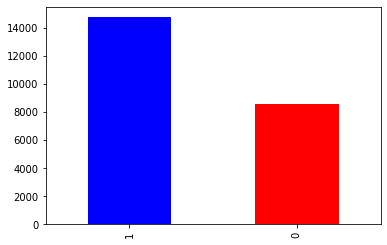

In [8]:
pd.Series(target).value_counts().plot(kind='bar', color=['blue','red'])

Non molto sbilanciata come target... ok.

Prepariamo tutto l'occorrente:

In [7]:
db_final.to_csv('dataset/db_modelli.csv')
db_final.columns

Index(['test_cas', 'species', 'conc1_type', 'exposure_type',
       'obs_duration_mean', 'conc1_mean', 'atom_number', 'alone_atom_number',
       'bonds_number', 'doubleBond', 'tripleBond', 'ring_number', 'Mol',
       'MorganDensity', 'LogP', 'class', 'tax_order', 'family', 'genus',
       'oh_count'],
      dtype='object')

In [13]:
# è la colonna conc1_mean di db_final
target

array([1, 1, 1, ..., 0, 0, 0])

Va fatto l'encoding delle variabili discrete

# Encoding varibiali categoriche

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Questo dataset non viene mai toccato--> è punto di riferimento
db = pd.read_csv('dataset/db_modelli.csv').drop(columns='Unnamed: 0')
db.head()

,test_cas,species,conc1_type,exposure_type,obs_duration_mean,conc1_mean,atom_number,alone_atom_number,bonds_number,doubleBond,tripleBond,ring_number,Mol,MorganDensity,LogP,class,tax_order,family,genus,oh_count
0,100-00-5,rerio,F,F,48.0,15.0,0.317908,2,0.488106,1,0,1.0,0.535725,1.3,2.2482,Actinopterygii,Cypriniformes,Cyprinidae,Danio,0
1,100-00-5,rerio,F,F,96.0,15.0,0.317908,2,0.488106,1,0,1.0,0.535725,1.3,2.2482,Actinopterygii,Cypriniformes,Cyprinidae,Danio,0
2,100-01-6,rerio,F,S,96.0,87.6,0.317908,2,0.488106,1,0,1.0,0.510371,1.3,1.1770,Actinopterygii,Cypriniformes,Cyprinidae,Danio,0
3,100-01-6,idus,F,AQUA,48.0,35.0,0.317908,2,0.488106,1,0,1.0,0.510371,1.3,1.1770,Actinopterygii,Cypriniformes,Cyprinidae,Leuciscus,0
4,100-01-6,latipes,A,S,24.0,68.0,0.317908,2,0.488106,1,0,1.0,0.510371,1.3,1.1770,Actinopterygii,Beloniformes,Adrianichthyidae,Oryzias,0


Cosa fare del composto? Per ora la levo...

In [86]:
print('''Il numero di composti sono {}'''.format(len(db.test_cas.unique())))

Il numero di composti sono 2621


In [87]:
# db con sole variabili categoriche
obj_db = db.select_dtypes('object')
obj_db.head()

,test_cas,species,conc1_type,exposure_type,class,tax_order,family,genus
0,100-00-5,rerio,F,F,Actinopterygii,Cypriniformes,Cyprinidae,Danio
1,100-00-5,rerio,F,F,Actinopterygii,Cypriniformes,Cyprinidae,Danio
2,100-01-6,rerio,F,S,Actinopterygii,Cypriniformes,Cyprinidae,Danio
3,100-01-6,idus,F,AQUA,Actinopterygii,Cypriniformes,Cyprinidae,Leuciscus
4,100-01-6,latipes,A,S,Actinopterygii,Beloniformes,Adrianichthyidae,Oryzias


In [88]:
from sklearn.preprocessing import LabelEncoder

# Creo db di variabili categoriche con encoding
obj_db_enc = pd.DataFrame()

lb_enc = LabelEncoder()
obj_db_enc['conc1_type_enc'] = lb_enc.fit_transform(obj_db['conc1_type'])


In [89]:
obj_db.conc1_type.unique()

array(['F', 'A', 'D', 'T', 'L', 'U'], dtype=object)

In [90]:
obj_db_enc.conc1_type_enc.unique()

array([2, 0, 1, 4, 3, 5])

In [127]:

obj_db_enc = pd.DataFrame()

for col in obj_db.columns:
    lb_enc = LabelEncoder()
    new_var = col + '_enc'
    obj_db_enc[new_var] = lb_enc.fit_transform(obj_db[col])
    
    

In [128]:
obj_db_enc.drop(columns = ['test_cas_enc','species_enc'], inplace = True)
obj_db_enc

,conc1_type_enc,exposure_type_enc,class_enc,tax_order_enc,family_enc,genus_enc
0,2,2,0,9,34,79
1,2,2,0,9,34,79
2,2,8,0,9,34,79
3,2,0,0,9,34,133
4,0,8,0,5,1,181
...,...,...,...,...,...,...
23327,2,8,0,9,34,265
23328,2,8,0,9,34,265
23329,2,7,0,22,76,175
23330,2,7,0,22,76,175


# Prova modelli senza variabili categoriche

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Questo dataset non viene mai toccato--> è punto di riferimento
db = pd.read_csv('dataset/db_modelli.csv').drop(columns='Unnamed: 0')
db

,test_cas,species,conc1_type,exposure_type,obs_duration_mean,conc1_mean,atom_number,alone_atom_number,bonds_number,doubleBond,tripleBond,ring_number,Mol,MorganDensity,LogP,class,tax_order,family,genus,oh_count
0,100-00-5,rerio,F,F,48.0,15.0,0.317908,2,0.488106,1,0,1.0,0.535725,1.300000,2.2482,Actinopterygii,Cypriniformes,Cyprinidae,Danio,0
1,100-00-5,rerio,F,F,96.0,15.0,0.317908,2,0.488106,1,0,1.0,0.535725,1.300000,2.2482,Actinopterygii,Cypriniformes,Cyprinidae,Danio,0
2,100-01-6,rerio,F,S,96.0,87.6,0.317908,2,0.488106,1,0,1.0,0.510371,1.300000,1.1770,Actinopterygii,Cypriniformes,Cyprinidae,Danio,0
3,100-01-6,idus,F,AQUA,48.0,35.0,0.317908,2,0.488106,1,0,1.0,0.510371,1.300000,1.1770,Actinopterygii,Cypriniformes,Cyprinidae,Leuciscus,0
4,100-01-6,latipes,A,S,24.0,68.0,0.317908,2,0.488106,1,0,1.0,0.510371,1.300000,1.1770,Actinopterygii,Beloniformes,Adrianichthyidae,Oryzias,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23327,8015-35-8,hakonensis,F,S,48.0,1.3,0.547662,0,0.678290,2,0,2.0,0.749544,0.703704,5.5670,Actinopterygii,Cypriniformes,Cyprinidae,Tribolodon,2
23328,8015-35-8,hakonensis,F,S,96.0,1.3,0.547662,0,0.678290,2,0,2.0,0.749544,0.703704,5.5670,Actinopterygii,Cypriniformes,Cyprinidae,Tribolodon,2
23329,8015-35-8,masou,F,R,24.0,0.9,0.547662,0,0.678290,2,0,2.0,0.749544,0.703704,5.5670,Actinopterygii,Salmoniformes,Salmonidae,Oncorhynchus,2
23330,8015-35-8,masou,F,R,48.0,0.7,0.547662,0,0.678290,2,0,2.0,0.749544,0.703704,5.5670,Actinopterygii,Salmoniformes,Salmonidae,Oncorhynchus,2


Una volta importato tutto il dataset comprensivo anche della variabile target (*conc1_mean*) faccio l'encoding binario della target e la levo dal dataset

In [16]:
target = db_final.conc1_mean.values
target = np.where(target > 1, 1, 0)
target

array([1, 1, 1, ..., 0, 0, 0])

In [18]:
use_db = db.copy().drop(columns = 'conc1_mean')

Tolgo le variabili che sono categoriche

In [24]:
# categorical variable
cat_var = use_db.dtypes[use_db.dtypes == 'object'].index

In [26]:
use_db.drop(columns = cat_var, inplace = True)
use_db

,obs_duration_mean,atom_number,alone_atom_number,bonds_number,doubleBond,tripleBond,ring_number,Mol,MorganDensity,LogP,oh_count
0,48.0,0.317908,2,0.488106,1,0,1.0,0.535725,1.300000,2.2482,0
1,96.0,0.317908,2,0.488106,1,0,1.0,0.535725,1.300000,2.2482,0
2,96.0,0.317908,2,0.488106,1,0,1.0,0.510371,1.300000,1.1770,0
3,48.0,0.317908,2,0.488106,1,0,1.0,0.510371,1.300000,1.1770,0
4,24.0,0.317908,2,0.488106,1,0,1.0,0.510371,1.300000,1.1770,0
...,...,...,...,...,...,...,...,...,...,...,...
23327,48.0,0.547662,0,0.678290,2,0,2.0,0.749544,0.703704,5.5670,2
23328,96.0,0.547662,0,0.678290,2,0,2.0,0.749544,0.703704,5.5670,2
23329,24.0,0.547662,0,0.678290,2,0,2.0,0.749544,0.703704,5.5670,2
23330,48.0,0.547662,0,0.678290,2,0,2.0,0.749544,0.703704,5.5670,2


Faccio un semplice gradient boosting

In [27]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(use_db.values, target, stratify = target,
                                                    test_size=0.33, random_state=42)


gbc = GradientBoostingClassifier()

In [29]:
gbc.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [30]:
y_pred_test = gbc.predict(X_test)

In [36]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn import metrics

def eval_metrics(y_true, y_pred):
    print("Test Confusion Matrix: \n", confusion_matrix(y_true, y_pred), "\n")

    print("Test accuracy: ", accuracy_score(y_true, y_pred), "\n")

    print("Test AUC: ", roc_auc_score(y_true, y_pred))
    
eval_metrics(y_test, y_pred_test)

Test Confusion Matrix: 
 [[1914  913]
 [ 481 4392]] 

Test accuracy:  0.818961038961039 

Test AUC:  0.7891678198219203


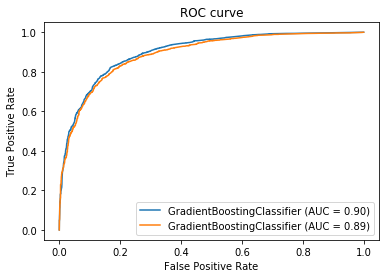

In [41]:
from sklearn.metrics import plot_roc_curve

ax = plt.gca()
ax.set_title("ROC curve")
plot_roc_curve(gbc, X_train, y_train, ax=ax)
plot_roc_curve(gbc, X_test, y_test, ax=ax)
plt.show()

Non c'è neanche overfitting, possiamo spingere sui parametri... tocca cross-validare tuttooooo...

Prima voglio fare una variable selection...

Feature ranking:
1. feature 7 (0.209078) Mol
2. feature 9 (0.165702) LogP
3. feature 8 (0.117661) MorganDensity
4. feature 3 (0.114142) bonds_number
5. feature 1 (0.094853) atom_number
6. feature 6 (0.084857) ring_number
7. feature 2 (0.063042) alone_atom_number
8. feature 4 (0.062153) doubleBond
9. feature 0 (0.038396) obs_duration_mean
10. feature 10 (0.032477) oh_count
11. feature 5 (0.017639) tripleBond


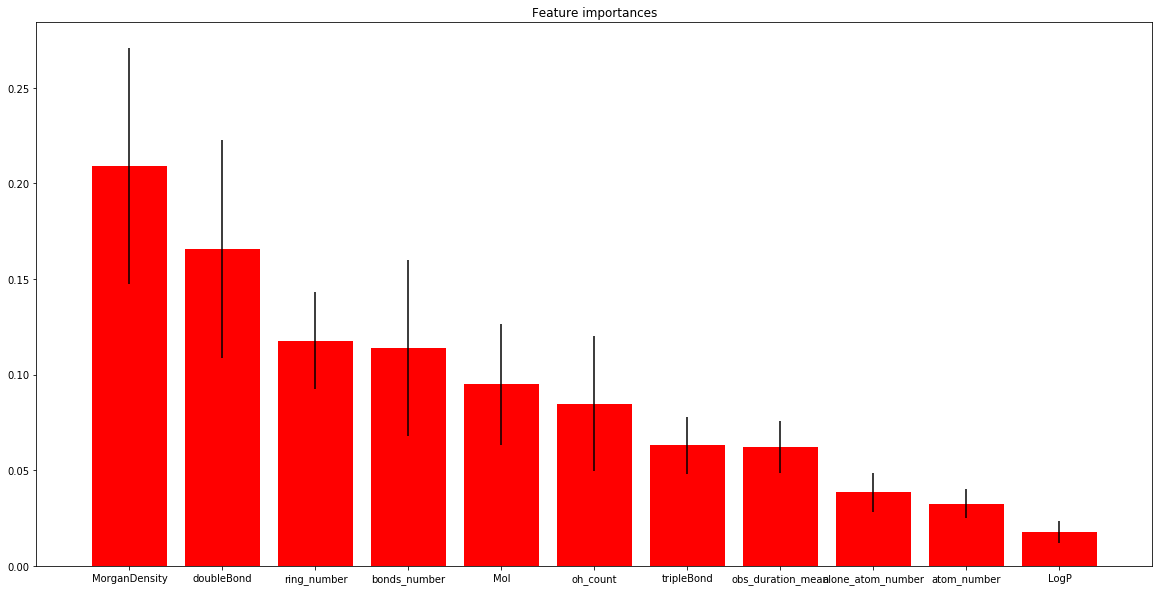

In [60]:
from sklearn.ensemble import ExtraTreesClassifier

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)
forest.fit(X_train, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]), use_db.columns[indices[f]])
    
# Plot the feature importances of the forest
plt.figure(figsize = [20,10])
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(indices, use_db.columns)
plt.xlim([-1, X_train.shape[1]])
plt.show()

Questo grafico ci dice quali colonne sono utili per il problema, cioè l'importanza relativa per la classificazione. Sono tutte molto utili.

The red bars are the impurity-based feature importances of the forest, along with their inter-trees variability.

Cross-validare i parametri...

# Modello con tutte le variabili (anche categoriche con encoding)

In [120]:
print(obj_db.shape)
obj_db_enc

(23332, 8)


,test_cas,conc1_type_enc,exposure_type_enc,class_enc,tax_order_enc,family_enc,genus_enc
0,100-00-5,2,2,0,9,34,79
1,100-00-5,2,2,0,9,34,79
2,100-01-6,2,8,0,9,34,79
3,100-01-6,2,0,0,9,34,133
4,100-01-6,0,8,0,5,1,181
...,...,...,...,...,...,...,...
23327,8015-35-8,2,8,0,9,34,265
23328,8015-35-8,2,8,0,9,34,265
23329,8015-35-8,2,7,0,22,76,175
23330,8015-35-8,2,7,0,22,76,175


In [121]:
use_db = db.drop(columns = db[cat_var[1:]])
use_db

,test_cas,obs_duration_mean,conc1_mean,atom_number,alone_atom_number,bonds_number,doubleBond,tripleBond,ring_number,Mol,MorganDensity,LogP,oh_count
0,100-00-5,48.0,15.0,0.317908,2,0.488106,1,0,1.0,0.535725,1.300000,2.2482,0
1,100-00-5,96.0,15.0,0.317908,2,0.488106,1,0,1.0,0.535725,1.300000,2.2482,0
2,100-01-6,96.0,87.6,0.317908,2,0.488106,1,0,1.0,0.510371,1.300000,1.1770,0
3,100-01-6,48.0,35.0,0.317908,2,0.488106,1,0,1.0,0.510371,1.300000,1.1770,0
4,100-01-6,24.0,68.0,0.317908,2,0.488106,1,0,1.0,0.510371,1.300000,1.1770,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23327,8015-35-8,48.0,1.3,0.547662,0,0.678290,2,0,2.0,0.749544,0.703704,5.5670,2
23328,8015-35-8,96.0,1.3,0.547662,0,0.678290,2,0,2.0,0.749544,0.703704,5.5670,2
23329,8015-35-8,24.0,0.9,0.547662,0,0.678290,2,0,2.0,0.749544,0.703704,5.5670,2
23330,8015-35-8,48.0,0.7,0.547662,0,0.678290,2,0,2.0,0.749544,0.703704,5.5670,2


In [132]:
# dataset per modelli con encoding

db_mod = pd.concat([use_db,obj_db_enc], axis = 1)
db_mod.head()

,test_cas,obs_duration_mean,conc1_mean,atom_number,alone_atom_number,bonds_number,doubleBond,tripleBond,ring_number,Mol,MorganDensity,LogP,oh_count,conc1_type_enc,exposure_type_enc,class_enc,tax_order_enc,family_enc,genus_enc
0,100-00-5,48.0,15.0,0.317908,2,0.488106,1,0,1.0,0.535725,1.3,2.2482,0,2,2,0,9,34,79
1,100-00-5,96.0,15.0,0.317908,2,0.488106,1,0,1.0,0.535725,1.3,2.2482,0,2,2,0,9,34,79
2,100-01-6,96.0,87.6,0.317908,2,0.488106,1,0,1.0,0.510371,1.3,1.1770,0,2,8,0,9,34,79
3,100-01-6,48.0,35.0,0.317908,2,0.488106,1,0,1.0,0.510371,1.3,1.1770,0,2,0,0,9,34,133
4,100-01-6,24.0,68.0,0.317908,2,0.488106,1,0,1.0,0.510371,1.3,1.1770,0,0,8,0,5,1,181


In [130]:
db_mod.to_csv('dataset/db_modelli_encoded.csv')

# Gradient Boosting con Encoding

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

db_mod = pd.read_csv('dataset/db_modelli_encoded.csv').drop(columns=['Unnamed: 0','test_cas'])
db_mod.shape

(23332, 18)

In [6]:
# Faccio l'encoding di conc1_mean
target = db_mod.conc1_mean.values
target = np.where(target > 1, 1, 0)
# elimino la colonna in db_mod

db_mod.drop(columns='conc1_mean', inplace = True)
print(target)
db_mod.head()

[1 1 1 ... 0 0 0]


,obs_duration_mean,atom_number,alone_atom_number,bonds_number,doubleBond,tripleBond,ring_number,Mol,MorganDensity,LogP,oh_count,conc1_type_enc,exposure_type_enc,class_enc,tax_order_enc,family_enc,genus_enc
0,48.0,0.317908,2,0.488106,1,0,1.0,0.535725,1.3,2.2482,0,2,2,0,9,34,79
1,96.0,0.317908,2,0.488106,1,0,1.0,0.535725,1.3,2.2482,0,2,2,0,9,34,79
2,96.0,0.317908,2,0.488106,1,0,1.0,0.510371,1.3,1.1770,0,2,8,0,9,34,79
3,48.0,0.317908,2,0.488106,1,0,1.0,0.510371,1.3,1.1770,0,2,0,0,9,34,133
4,24.0,0.317908,2,0.488106,1,0,1.0,0.510371,1.3,1.1770,0,0,8,0,5,1,181


In [7]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(db_mod.values, target, stratify = target,
                                                    test_size=0.33, random_state=42)


gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)

y_pred_test = gbc.predict(X_test)

from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn import metrics

def eval_metrics(y_true, y_pred):
    print("Test Confusion Matrix: \n", confusion_matrix(y_true, y_pred), "\n")

    print("Test accuracy: ", accuracy_score(y_true, y_pred), "\n")

    print("Test AUC: ", roc_auc_score(y_true, y_pred))
    
eval_metrics(y_test, y_pred_test)

Test Confusion Matrix: 
 [[1984  843]
 [ 508 4365]] 

Test accuracy:  0.8245454545454546 

Test AUC:  0.7987780679851895


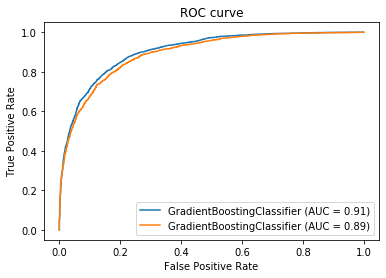

In [9]:
from sklearn.metrics import plot_roc_curve

ax = plt.gca()
ax.set_title("ROC curve")
plot_roc_curve(gbc, X_train, y_train, ax=ax)
plot_roc_curve(gbc, X_test, y_test, ax=ax)
plt.show()